In [1]:
import numpy as np

from lib.mnist_aug.mnist_augmenter import DataManager, MNISTAug

In [2]:
aug = MNISTAug()
dm = DataManager()
dm.load()

In [3]:
aug.max_objects = 10
aug.min_objects = 4
aug.spacing = 1
aug.scaling_mean = 1
aug.scaling_sd = 0.25
aug.overflow = 0

In [4]:
x_train, y_train = aug.get_augmented(dm.x_train, dm.y_train, 10)
x_test, y_test = aug.get_augmented(dm.x_test, dm.y_test, 2)

In [5]:
x_train = x_train.reshape(-1, 112, 112, 1)
x_test = x_test.reshape(-1, 112, 112, 1)

/Users/akhildevarashetti/code/ml_gallery/ml_py/lib/mnist_aug/mnist_augmenter.py:216: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[{'class': 1,
  'class_one_hot': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'x1': 28,
  'y1': 3,
  'x2': 50,
  'y2': 25,
  'cx': 39.0,
  'cy': 14.0,
  'height': 22,
  'width': 22},
 {'class': 2,
  'class_one_hot': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  'x1': 91,
  'y1': 42,
  'x2': 109,
  'y2': 60,
  'cx': 100.0,
  'cy': 51.0,
  'height': 18,
  'width': 18},
 {'class': 3,
  'class_one_hot': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  'x1': 10,
  'y1': 74,
  'x2': 38,
  'y2': 102,
  'cx': 24.0,
  'cy': 88.0,
  'height': 28,
  'width': 28},
 {'class': 2,
  'class_one_hot': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  'x1': 72,
  'y1': 75,
  'x2': 104,
  'y2': 107,
  'cx': 88.0,
  'cy': 91.0,
  'height': 32,
  'width': 32},
 {'class': 7,
  'class_one_hot': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
  'x1': 44,
  'y1': 74,
  'x2': 55,
  'y2': 85,
  'cx': 49.5,
  'cy': 79.5,
  'height': 11,
  'width': 11},
 {'class': 5,
  'class_one_hot': array([0., 0.

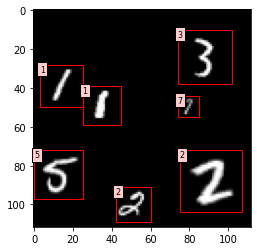

In [6]:
test_index = 3
DataManager.plot_num(x_train[test_index].reshape((112, 112)), y_train[test_index])
y_train[test_index]

In [7]:
def to_one_hot(x, num_classes=10):
  b = np.zeros((len(x), num_classes), dtype=np.float32)
  b[np.arange(len(x)), x] = 1
  return b

In [8]:
img_width = 112
n_anchors_row = 4
n_anchors = n_anchors_row ** 2
anchor_width = 28
anchor_grid_spacing = img_width / n_anchors_row

anchor_centers = []
for i in range(n_anchors_row):
  anchor_row = []
  for j in range(n_anchors_row):
    anchor_row.append([
      j * anchor_grid_spacing + anchor_grid_spacing / 2,
      i * anchor_grid_spacing + anchor_grid_spacing / 2,
    ])
  anchor_centers.append(anchor_row)
anchor_centers = np.array(anchor_centers).reshape((-1, 2))

In [9]:
def get_fractional_difference(anchor, bounding_box):
  a_box = anchor
  b_box = bounding_box

  cx_d = (b_box['cx'] - a_box[0]) / img_width
  cy_d = (b_box['cy'] - a_box[1]) / img_width
  wd = (b_box['width'] - anchor_width) / img_width

  return cx_d, cy_d, wd

def get_units_from_diff(anchors, bounding_boxes):
    diffs = np.zeros((len(anchors), 3))
    for i in range(len(anchors)):
        diffs[i][0] = bounding_boxes[i][0] * img_width + anchors[i][0]
        diffs[i][1] = bounding_boxes[i][1] * img_width + anchors[i][1]
        diffs[i][2] = bounding_boxes[i][2] * img_width + anchor_width

    return diffs

In [10]:
def get_iou(anchor_center, bounding_box):

    half_anchor_width = anchor_width / 2
    boxA = [
        anchor_center[0]-half_anchor_width,
        anchor_center[1]-half_anchor_width,
        anchor_center[0]+half_anchor_width,
        anchor_center[1]+half_anchor_width
    ]
    boxB = [bounding_box['x1'], bounding_box['y1'], bounding_box['x2'], bounding_box['y2']]

    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [11]:
def get_positive_anchors(y_batch):
    """
    1. For Each item in the batch:
    2. For each anchor box:
    - For each bounding box:
        - Find the IoU.
    - Pick bounding box with highest IoU for that anchor.
    - # TODO: Pick the anchor with the highest IoU for that bounding box.
    - If highest IoU is < 0.3, then continue 1.
    # - Create the difference units for the anchor and the bounding box as y
    - Now add the anchor box and bounding box into a map.
    """
    all_positive_pairs = []
    for batch_i in range(len(y_batch)):
        positive_pairs_batch = []
        max_iou_b = {}
        max_iou_a = {}

        # ---------- The two loops --------------

        for anchor_i in range(len(anchor_centers)):
            for bb_i in range(len(y_batch[batch_i])):

                b_box = y_batch[batch_i][bb_i]
                a_box = anchor_centers[anchor_i]

                iou = get_iou(a_box, b_box)
                default_iou = {'iou': 0, 'bb_i': -1, 'ab_i': -1}

                # --------------- Find max IoUs ------------------

                if iou > max_iou_b.get(bb_i, default_iou)['iou']:
                    max_iou_b[bb_i] = {
                        'iou': iou,
                        'bb_i': bb_i,
                        'ab_i': anchor_i
                    }

                if iou > 0.5 and iou > max_iou_a.get(anchor_i, default_iou)['iou']:
                    max_iou_a[anchor_i] = {
                        'iou': iou,
                        'bb_i': bb_i,
                        'ab_i': anchor_i
                    }

        # --------- Merge both max ious ----------------

        positive_pairs = [max_iou_b[index] for index in list(max_iou_b.keys())]
        for index in list(max_iou_a.keys()):
            if max_iou_a[index] not in positive_pairs:
                positive_pairs.append(max_iou_a[index])
        all_positive_pairs.append(positive_pairs)

    return all_positive_pairs

In [12]:
positives = get_positive_anchors(y_test[:2])
for positive in positives:
  print(len(positive))
n_anchors

10
5


16

In [13]:
def get_y_d(y):
  """
  Find all the positive anchor pairs.
  for each of y:
    for each pair in yi:
      find fractional difference in anchor and bounding box.
      append the fractional difference to the pair.
  """
  y_d = []
  positive_pairs = get_positive_anchors(y)
  for yi in range(len(y)):
    diffs = []
    for pair_i in range(len(y[yi])):
      pair = positive_pairs[yi][pair_i]
      anchor = anchor_centers[pair['ab_i']]
      bounding_box = y[yi][pair['bb_i']]
      cx_d, cy_d, wd = get_fractional_difference(anchor, bounding_box)
      diffs.append((cx_d, cy_d, wd, pair['ab_i'], pair['bb_i']))
    y_d.append(np.array(diffs))
  return y_d

In [14]:
y_train_d = get_y_d(y_train)
y_test_d = get_y_d(y_test)

In [15]:
import tensorflow as tf

In [18]:
def get_model():
    cnn = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(10, (3,3), padding='same', input_shape=(112, 112, 1), activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(20, (3,3), padding='same', strides=2, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(40, (3,3), strides=2, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(80, (3,3), padding='same', strides=2, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(160, (3,3), strides=2, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.3),
    ])

    input_image = tf.keras.layers.Input(shape=(112, 112, 1))
    features = cnn(input_image)

    confidence_predictor = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(1024,)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_anchors, activation='sigmoid')
    ])

    confidences = confidence_predictor(features)

    box_predictor = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, input_shape=(1024,), activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(3 * n_anchors, activation='tanh')
    ])

    box_predictions = box_predictor(features)

    return tf.keras.models.Model(input_image, [box_predictions, confidences])


model = get_model()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 112, 112, 1) 0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 1024)         6052664     input_3[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 48)           549424      sequential_6[0][0]               
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 16)           533008      sequential_6[0][0]               
Total params: 7,135,096
Trainable params: 7,135,096
Non-trainable params: 0
___________

In [ ]:
def my_loss_fn(y_true, y_pred):
    """
    1. find losses for each positive anchor
    2. Sum them all up.
    3. Create an array of n_anchors length for target confidences.
    4. Make confidences 1 for positive indices.
    5. Find losses for confidences.
    return: float tensor
    """
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

model.compile(optimizer='adam', loss=my_loss_fn, metrics=['accuracy'])
model.summary()

In [19]:
epochs = 1
batch_size = 16

model.fit(x_train, y_train_d, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test_d))

ValueError: Data cardinality is ambiguous:
  x sizes: 10
  y sizes: 10, 8, 8, 7, 8, 8, 6, 4, 8, 10
Please provide data which shares the same first dimension.